# Exploring Hate Crimes and Antisemitism

## Introduction  
Hate crimes, particularly those targeting specific groups like antisemitism, pose a significant challenge globally. In this project, we aim to analyze hate crime data to understand trends related to antisemitic incidents.

The Federal Bureau of Investigation reported 6,270 hate crimes in the US in 2016, 7,868 in 2019, and 11,643 in 2022--an 85% increase over six years. In response to this alarming surge in hate crimes across the nation, we present a comprehensive model aimed at tracking and analyzing this disturbing trend. The escalating incidence of hate-motivated offenses underscores the urgent need for proactive measures to understand the trends so they can be addressed.

The dataset sources we'll utilize include the FBI data, which provides comprehensive hate crime records from 1991 to 2022, and additional data from the Anti-Defamation League (ADL) for recent years.


In [1]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeRegressor

C:\Users\eitan\AppData\Local\Temp\ipykernel_17216\4025613340.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Data Collection 

This tutorial utilizes a dataset acquired from the Federal Bureau of Investigation. The hate_crime.csv file contains 241,664 hate crimes between 1991 and 2022. 

The database was manually downloaded from a public FBI repository and added to this repository as a csv file and then accessed through a read_csv call, reading the spreadsheet into a DataFrame.

Each hate crime is identified based on the following categories: 
incident_id, data_year, ori, pug_agency_name, pub_agency_unit, agency_type_name, state_abbr, state_name, division_name, region_name, population_group_code, population_group_description, incident_date, adult_victim_count, juvenile_victim_count, total_offender_count, adult_offender_count, juvenile_offender_count, offender_race, offender_ethnicity, victim_count, offense_name, total_individual_victims, location_name, bias_desc, victim_types, multiple_offense, multiple_bias.

For the purpose of this study we are considering data_year (year the incident was reported), state_name (where the incident occurred), agency_type_name (where it occurred--city, county, university, etc), bias_desc (what subgroups were impacted in the incident), offense_name (what type of incident occurred), and incident_date (date the incident occurred). In addition to not requiring the other columns for this particular study, these columns were all completed for every data entry. All other columns were filtered out of the dataframe.

The bias_desc identifies the various types of hate crimes listed, identifying each by the group targeted by the attack.

Before beginning data analysis and prediction, we cleaned the data to remove unneeded columns and to combine similar categories for better representation of types of hate crimes.


In [2]:
#Load from csv file
file_path = 'hate_crime.csv'

#read into a DataFrame
all_data = pd.read_csv(file_path)

We collected and processed additional hate crime data from the ADL for recent years to complement the FBI dataset.

In [ ]:
#import data from the ADL on antisemetic incidents 
adl_file_path = 'HEATMapData (1).csv'

#read into a DataFrame
adl_data = pd.read_csv(adl_file_path)

## Data Processing
In this section, we focus on selecting the columns that are relevant for our analysis from the hate crime dataset. We start by examining all the column names to understand the available features in our dataset. This step helps us identify which columns we need to proceed with for further analysis, as well as to clearly display the columns included. Next, we check for missing values across all columns to assess the data quality. If there are missing values, we'll need to decide how to handle them. In this case, we may choose to drop rows with missing data assuming they are unneeded for our later analyses. 

Finally, we create a new DataFrame named only_relevant containing only the selected relevant columns for our analysis.

We followed a similar process for the ADL data. 

In [3]:
#Preprocessing: Selecting relevant columns
column_names = all_data.columns.tolist()
print(column_names)

# Checking missing values
missing_values = all_data.isnull().sum()
print("Missing Values:")
#print(missing_values)

# Selecting relevant data that we wish to remain in our Dataframe
only_relevant = all_data[['data_year','state_name', 'agency_type_name', 'bias_desc', 'offense_name', 'incident_date']]
print(only_relevant)


['incident_id', 'data_year', 'ori', 'pug_agency_name', 'pub_agency_unit', 'agency_type_name', 'state_abbr', 'state_name', 'division_name', 'region_name', 'population_group_code', 'population_group_description', 'incident_date', 'adult_victim_count', 'juvenile_victim_count', 'total_offender_count', 'adult_offender_count', 'juvenile_offender_count', 'offender_race', 'offender_ethnicity', 'victim_count', 'offense_name', 'total_individual_victims', 'location_name', 'bias_desc', 'victim_types', 'multiple_offense', 'multiple_bias']
Missing Values:
        data_year state_name       agency_type_name  \
0            1991   Arkansas                   City   
1            1991   Arkansas                   City   
2            1991   Arkansas                   City   
3            1991   Arkansas                   City   
4            1991   Arkansas                 County   
...           ...        ...                    ...   
241658       2022    Wyoming                   City   
241659      

We processed the ADL data, collecting the sametypes of data from the set. 

In [ ]:
adl_relevant = adl_data[['date','state', 'type', 'description']]

# Create new column of "data_year"
adl_relevant['date'] = pd.to_datetime(adl_relevant['date'], errors='coerce')

# Extract year and create a new column
adl_relevant['data_year'] = adl_relevant['date'].dt.year

# Split the 'type' column into two separate columns
adl_relevant[['bias_type', 'offense type']] = adl_relevant['type'].str.split(':', n=1, expand=True)

# Drop the original 'type' column
adl_relevant.drop(columns=['type'], inplace=True)

## Exploratory Data Analysis:
Exploratory Data Analysis serves as a crucial initial step in understanding the multifaceted landscape of hate crimes. By delving into both Federal Bureau of Investigation (FBI) and Anti-Defamation League (ADL) datasets, we embark on a comprehensive journey to uncover temporal, spatial, and categorical insights into hate-motivated incidents across the United States. Through meticulous data cleaning, visualization, and interpretation, we attempt to unveil hidden patterns, identify prevalent trends, and shed light on the diverse nature of hate crimes targeting various demographic groups. 

### Exploratory Data Analysis (EDA) on FBI Hate Crime Data
FBI Hate Crime Data:
In this section, we delve into the FBI dataset containing hate crime reports spanning several years. We are specifically focusing on crime rates over time, states in which they occur, types of offenses and the biases that motivate the crimes. Having already cleaned the data, handled missing values, and selected relevant columns for investigation, we can now detect trends and begin to analyze the data. 

Key Steps in FBI EDA:  
- Temporal Trends Analysis: We analyze temporal trends by examining the total number of hate crimes reported each year. Line plots and bar graphs are used to visualize changes in hate crime counts over time and identify any notable spikes or declines.

- Spatial Analysis: Spatial analysis involves exploring the geographical distribution of hate crimes. Bar graphs and choropleth maps are employed to visualize hate crime incidence by state, enabling us to identify regions with higher prevalence and variations over time.

- Bias Type Distribution: We investigate the distribution of hate crimes across different bias types. Pie charts and bar graphs illustrate the proportions of hate crimes targeting various groups, such as racial, religious, or LGBTQ+ communities.



#### Total Hate Crimes Over the Years

We start by examining trends of the total number of hate crimes reported each year, betweeen 1990 and 2022. ADD WHAT WE ACTUALLY DID AND WHAT WE FOUND. 

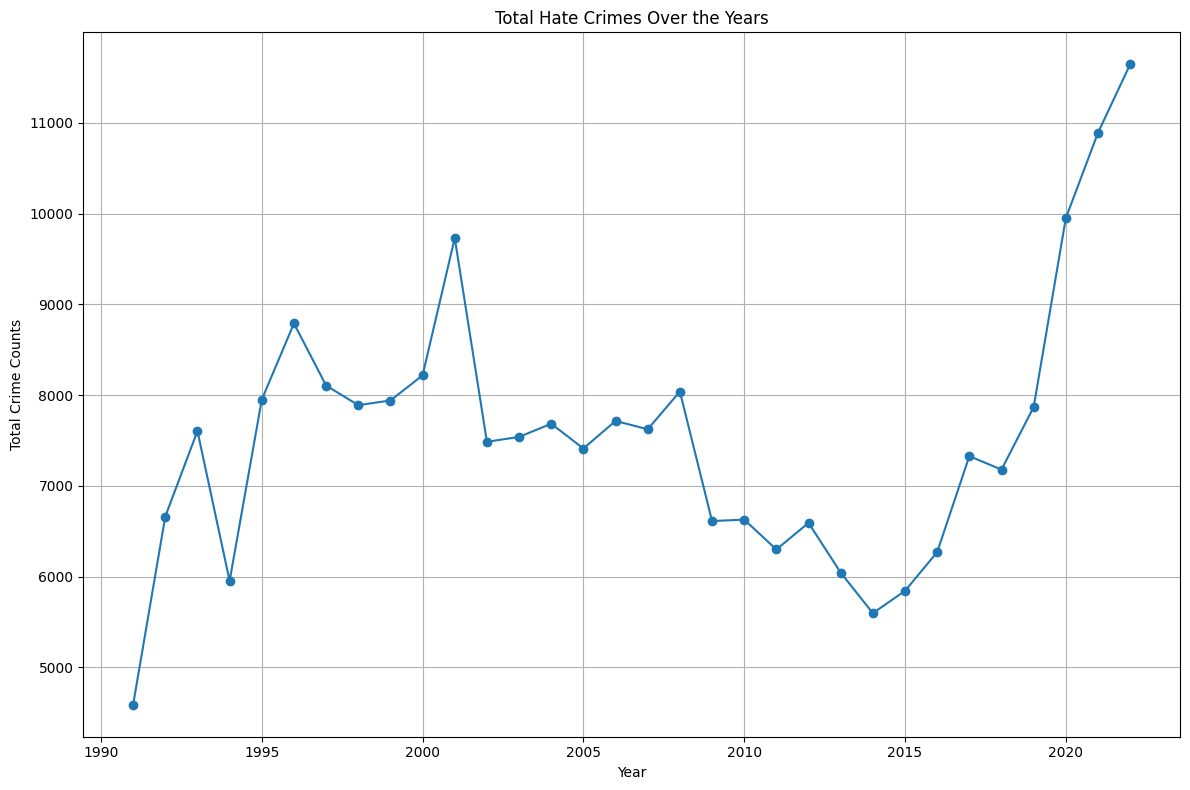

In [4]:
# Group the data by 'data_year' and count the total number of hate crimes for each year
total_crime_counts = only_relevant.groupby('data_year').size().reset_index(name='total_crimes')

# Plot total hate crimes over the years
plt.figure(figsize=(12, 8))
plt.plot(total_crime_counts['data_year'], total_crime_counts['total_crimes'], marker='o', linestyle='-')
plt.title('Total Hate Crimes Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Crime Counts')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Hate Crimes per Bias Type
Next, we explore hate crimes categorized by different bias types.  
This line plot illustrates the distribution of hate crimes across different bias types over the years.
Further detail will be provided below--This is meant to demonstrate the quantity of bias types analyzed, as well as a representation of some of those with higher quantities.

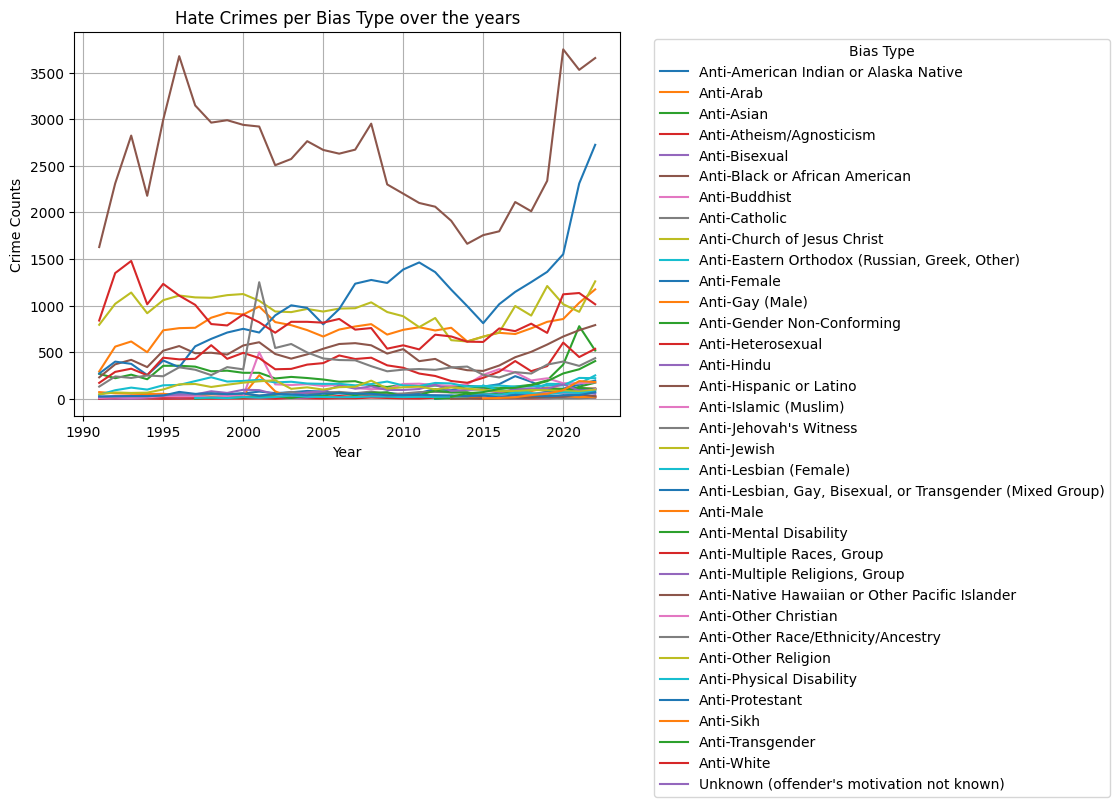

In [5]:
#Since the dataset includes multiple types of biases in each bias description, we first need to separate each bias type. 

og_expand = only_relevant.assign(bias_desc=only_relevant['bias_desc'].str.split(', ')).explode('bias_desc')
expanded_data = og_expand.assign(bias_desc=only_relevant['bias_desc'].str.split(';')).explode('bias_desc')

#We then calculate crime counts per bias type per year
crime_counts = expanded_data.groupby(['data_year', 'bias_desc']).size().reset_index(name='count_of_crimes')

pivot_table = crime_counts.pivot(index='data_year', columns='bias_desc', values='count_of_crimes')

for category in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[category], label=category)

plt.title('Hate Crimes per Bias Type over the years')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()

plt.legend(title='Bias Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

#### Percentage of Hate Crimes by State
Now, let's analyze the geographical distribution of hate crimes.  
This bar graph shows the percentage of hate crimes reported in each state. 


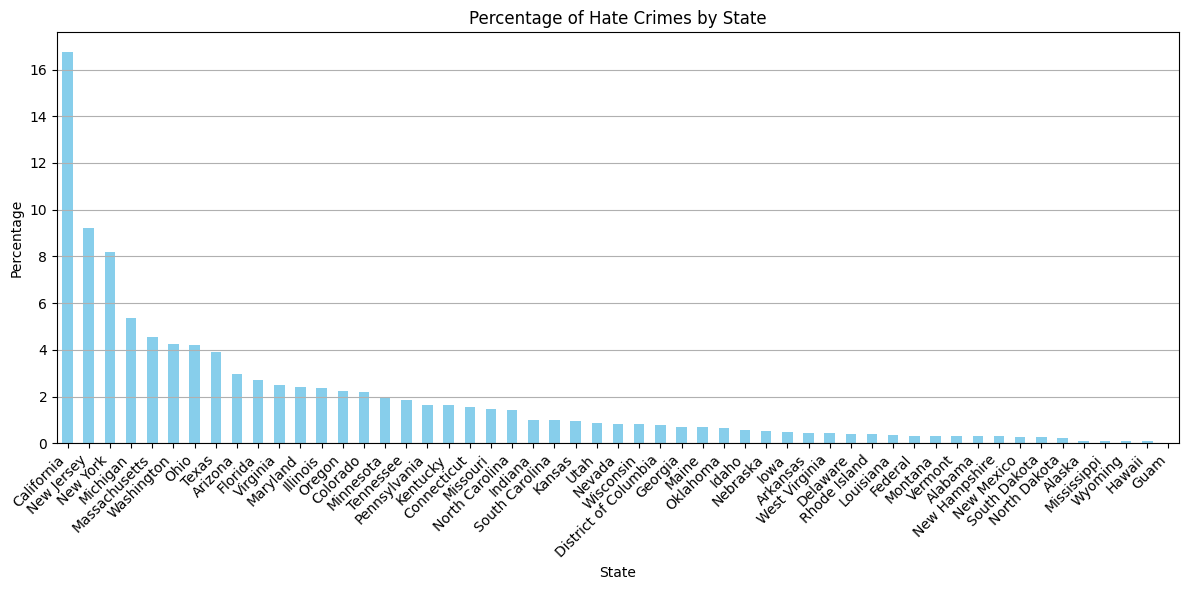

In [9]:
percentage_per_state = (expanded_data['state_name'].value_counts() / len(expanded_data)) * 100


# Plotting
plt.figure(figsize=(12, 6))
percentage_per_state.plot(kind='bar', color='skyblue')
plt.title('Percentage of Hate Crimes by State')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines along the y-axis
plt.tight_layout()
plt.show()


#### Hate Crimes broken down into different offense types

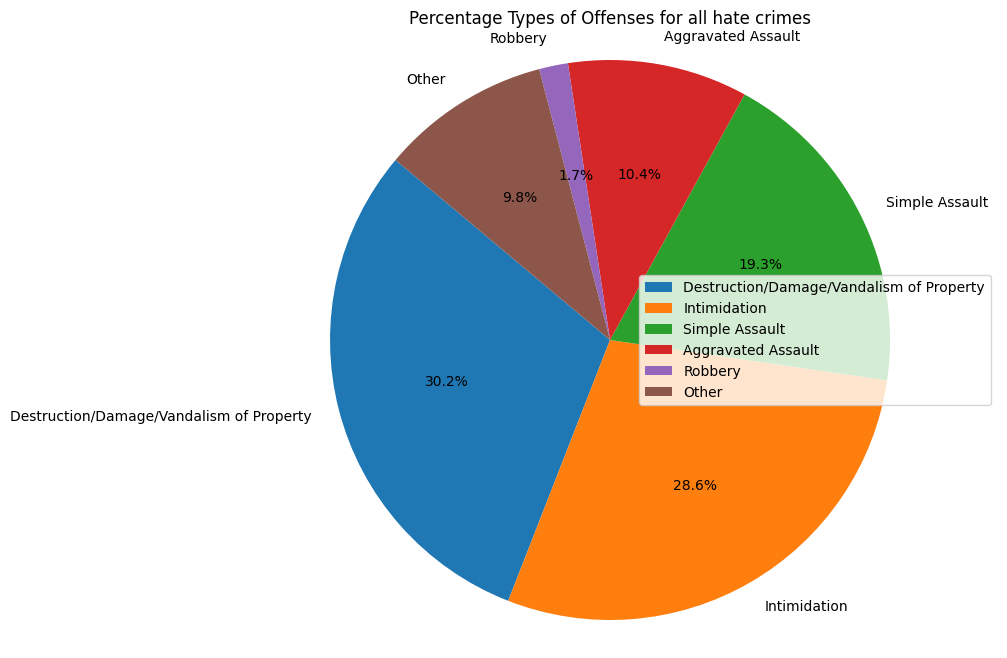

In [23]:
percentage_per_state = (expanded_data['offense_name'].value_counts() / len(expanded_data)) * 100


# Filter out categories with percentages less than 1.5%
other_threshold = 1.5
main_categories = percentage_per_state[percentage_per_state >= other_threshold]
other_categories = percentage_per_state[percentage_per_state < other_threshold]

# Combine the filtered categories into an "other" category
other_percentage = other_categories.sum()
main_categories['Other'] = other_percentage

# Plotting
plt.figure(figsize=(10, 8))
main_categories.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Percentage Types of Offenses for all hate crimes')
plt.ylabel('')  # Remove the y-label
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add legend with the 'Other' category
plt.legend(main_categories.index, loc='best')

plt.show()


### Focus on antisemitic Hate Crimes in the FBI dataset.
Now that we have provided a representation of various forms of hate crimes, we are focusing in specifically on antisemitism. We begin with a visualization of antisemitism and will follow it up with a hypothesis and further models. 

#### Hate Crimes with Anti-Jewish Bias Over the Years
This line plot displays the trend of antisemitic hate crimes reported each year.

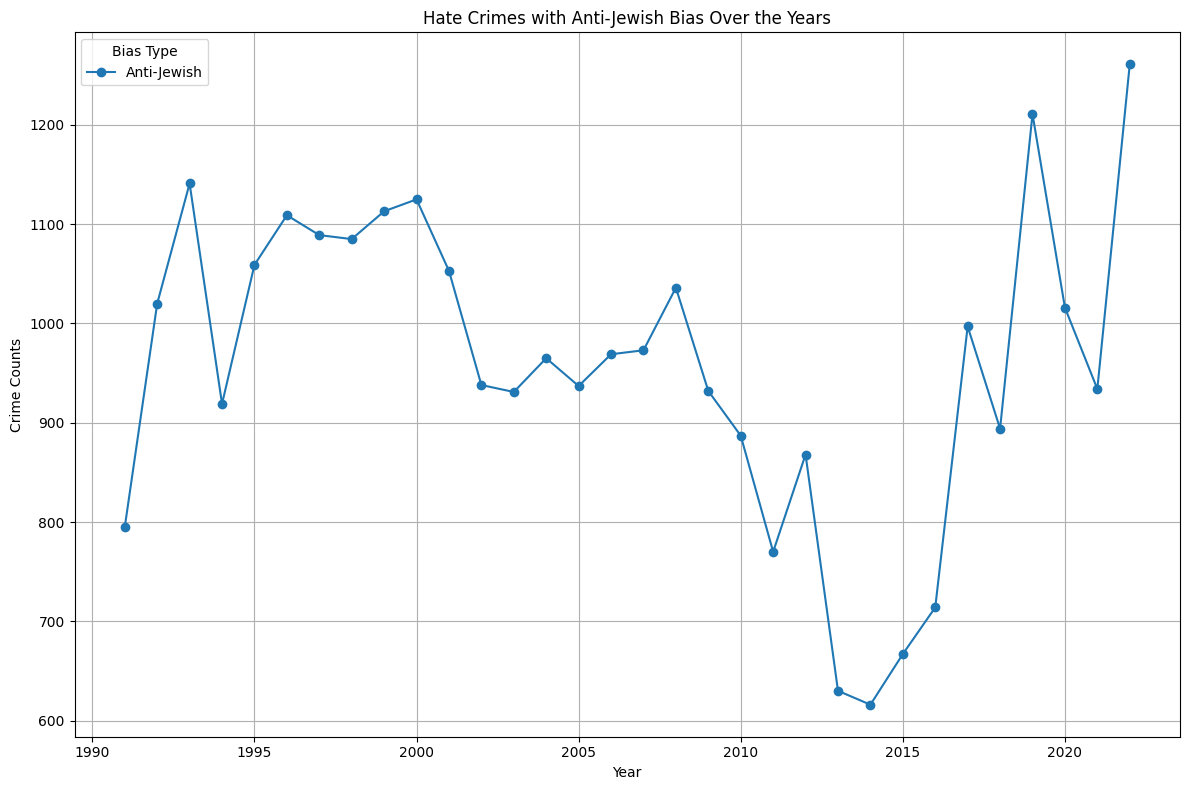

In [14]:
# Filter the expanded_data DataFrame to include only the rows with the "Anti-Jewish" bias category
anti_jewish_data = expanded_data[expanded_data['bias_desc'] == 'Anti-Jewish']

# Group the filtered data by 'data_year' and count the number of hate crimes for each year
crime_counts_anti_jewish = anti_jewish_data.groupby('data_year').size().reset_index(name='count_of_crimes')

# Plotting
plt.figure(figsize=(12, 8))

plt.plot(crime_counts_anti_jewish['data_year'], crime_counts_anti_jewish['count_of_crimes'], marker='o', label='Anti-Jewish')

plt.title('Hate Crimes with Anti-Jewish Bias Over the Years')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Bias Type')
plt.show()


#### Percentage of Anti-Semitic Acts by State
Now, let's examine the geographical distribution of anti-Semitic hate crimes.  
This bar chart visualizes the percentage of anti-Semitic hate crimes reported in each state.


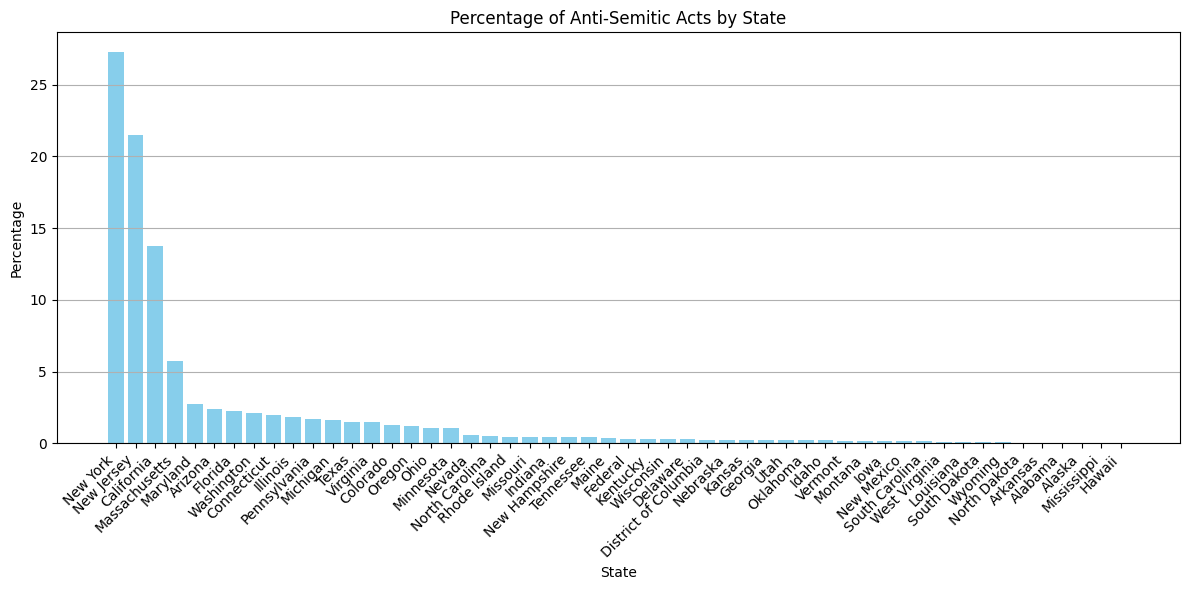

In [17]:
# Calculate the percentage of anti-Semitic acts by state
percentage_per_state = (anti_jewish_data['state_name'].value_counts() / len(anti_jewish_data)) * 100


# Plotting
plt.figure(figsize=(12, 6))
plt.bar(percentage_per_state.index, percentage_per_state, color='skyblue')

# Adding labels and title
plt.title('Percentage of Anti-Semitic Acts by State')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines along the y-axis
plt.tight_layout()

# Show plot
plt.show()


#### Types of Anti-Semitic Offenses
Lastly, let's explore the types of offenses associated with anti-Semitic hate crimes.  
This pie chart illustrates the distribution of different types of offenses associated with anti-Semitic hate crimes. 

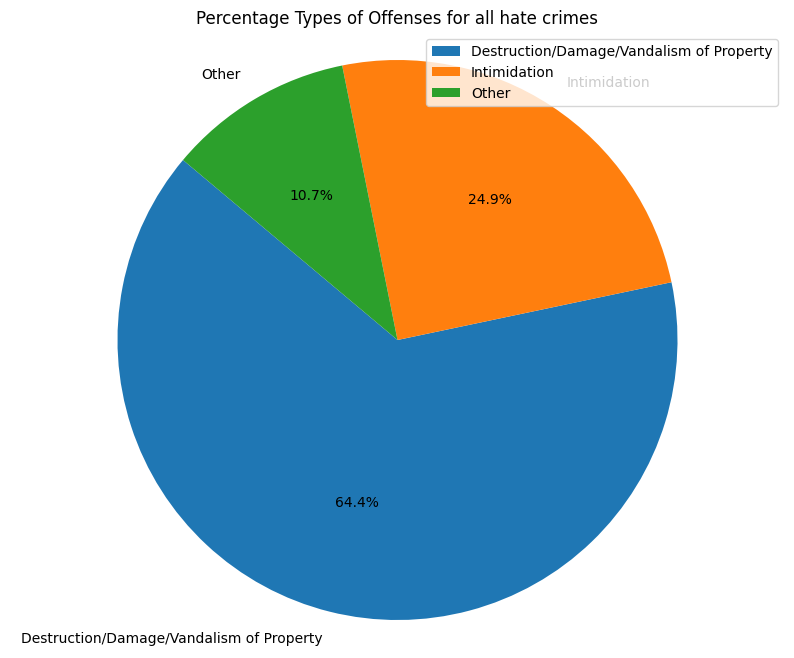

In [24]:
percentage_per_state = (anti_jewish_data['offense_name'].value_counts() / len(expanded_data)) * 100


# Filter out categories with percentages less than 1.5%
other_threshold = 1.5
main_categories = percentage_per_state[percentage_per_state >= other_threshold]
other_categories = percentage_per_state[percentage_per_state < other_threshold]

# Combine the filtered categories into an "other" category
other_percentage = other_categories.sum()
main_categories['Other'] = other_percentage

# Plotting
plt.figure(figsize=(10, 8))
main_categories.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Percentage Types of Offenses for all hate crimes')
plt.ylabel('')  # Remove the y-label
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Add legend with the 'Other' category
plt.legend(main_categories.index, loc='best')

plt.show()


### ADL Anti-Semitic Data:
In this section, we explore the ADL dataset, which provides insights into anti-Semitic incidents reported over recent years. EDA helps us understand the prevalence, nature, and distribution of anti-Semitic incidents across different regions and time periods.

Key Steps in EDA:

Data Cleaning and Preparation: Similar to the FBI data, we clean and preprocess the ADL dataset to ensure data quality and consistency. Missing values are handled, and relevant columns are selected for analysis.

Temporal Trends Analysis: We examine temporal trends in anti-Semitic incidents by plotting the number of incidents reported each year. Line plots highlight any changes or fluctuations in anti-Semitic activity over time.

Geographic Distribution Analysis: Spatial analysis involves visualizing the geographic distribution of anti-Semitic incidents. Bar graphs, choropleth maps, and pie charts depict the distribution of incidents by state, offering insights into regional variations and hotspots.

Incident Type Exploration: We explore the different types of anti-Semitic incidents reported in the dataset. Pie charts and bar graphs illustrate the prevalence of various types of incidents, such as harassment, vandalism, or assault.

In [ ]:
# BREAK THIS DOWN THE SAME WAY AND COMPARE TO THE FBI STATS. 

crime_counts = adl_relevant.groupby(['data_year', 'bias_type']).size().reset_index(name='count_of_crimes')

pivot_table = crime_counts.pivot(index='data_year', columns='bias_type', values='count_of_crimes')

for category in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[category], label=category)

plt.title('Hate Crimes per Bias Type over the years')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()

plt.legend(title='Bias Type', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


# Filter the data for anti-Jewish hate crimes
adl_antisemetic_data = adl_relevant[adl_relevant['bias_type'] == 'Antisemitic Incident']

# Group the filtered data by 'data_year' and count the number of hate crimes for each year
crime_counts_anti_jewish = adl_antisemetic_data.groupby('data_year').size().reset_index(name='count_of_crimes')

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(crime_counts_anti_jewish['data_year'], crime_counts_anti_jewish['count_of_crimes'], marker='o')
plt.title('Anti-Jewish Hate Crimes Over the Years')
plt.xlabel('Year')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()
plt.show()

# Group the data by 'state' and count the number of hate crimes for each state
crime_counts_per_state = adl_antisemetic_data['state'].value_counts()

# Plotting
plt.figure(figsize=(12, 8))
crime_counts_per_state.plot(kind='bar')
plt.title('Anti-Jewish Hate Crimes Per State')
plt.xlabel('State')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()
plt.show()


# Group the data by 'offense type' and count the number of hate crimes for each offense type
crime_counts_per_offense = adl_antisemetic_data['offense type'].value_counts()

# Plotting
plt.figure(figsize=(12, 8))
crime_counts_per_offense.plot(kind='bar')
plt.title('Anti-Jewish Hate Crimes by Offense Types')
plt.xlabel('Offense Type')
plt.ylabel('Crime Counts')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the percentage of anti-Jewish acts by state
percentage_per_state = (adl_antisemetic_data['state'].value_counts() / len(adl_antisemetic_data)) * 100

# Plotting
plt.figure(figsize=(10, 8))
percentage_per_state.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Anti-Jewish Acts by State')
plt.ylabel('')  # Remove the y-label
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Calculate the percentage of anti-Jewish crime types
percentage_per_offense = (adl_antisemetic_data['offense type'].value_counts() / len(adl_antisemetic_data)) * 100

# Plotting
plt.figure(figsize=(10, 8))
percentage_per_offense.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Anti-Jewish Offense Types')
plt.ylabel('')  # Remove the y-label
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

## Analysis, hypothesis testing, & ML

- Formulate hypotheses or research questions related to hate crimes or antisemitism.
- Conduct hypothesis tests or statistical analyses to answer these questions.
- Develop machine learning models to predict hate crime counts, identify trends, or classify hate crime incidents.
- Evaluate model performance and interpret the results.   



After seeing the different trends in hate crimes, we built a predictive model based on the FBI data for antisemitism over the years. We are going to build two models - one based on the FBI data and one based on an additional data repository acquired from the Anti-Defarmation League (ADL) that contains more recent data.
We are first going to process and perform eda on the ADL data, compare the data to the FBI data, and then build the models. 

In [ ]:
anti_jewish_data = expanded_data[expanded_data['bias_desc'] == 'Anti-Jewish'][['data_year', 'state_name']]

print(anti_jewish_data)


        data_year     state_name
13           1991        Arizona
19           1991        Arizona
26           1991        Arizona
38           1991        Arizona
39           1991        Arizona
...           ...            ...
241556       2022      Wisconsin
241580       2022      Wisconsin
241608       2022  West Virginia
241626       2022  West Virginia
241632       2022  West Virginia

[30654 rows x 2 columns]


#### Feature Engineering and Model Building
We split the data into features (X) and target variable (y), and perform one-hot encoding for categorical features. Then, we split the data into training and testing sets using the train_test_split function. We train a linear regression model to predict the hate crime counts based on the features. After training the model, we evaluate its performance using mean squared error (MSE). Additionally, we perform a chi-square test to analyze the independence between 'state_name' and 'hate_crime_count'. Lastly, we train a decision tree regression model and evaluate its performance using MSE. This analysis helps us understand the relationship between the occurrence of hate crimes and various factors such as time and location, and enables us to make predictions using machine learning models. 

In [ ]:
# Group the data by 'data_year' and 'state_name' and count the number of hate crimes for each group
hate_crime_counts = anti_jewish_data.groupby(['data_year', 'state_name']).size().reset_index(name='hate_crime_count')

# Create a new DataFrame with 'data_year', 'state_name', and 'hate_crime_count'
new_df = hate_crime_counts.copy()

X = new_df[['data_year', 'state_name']]
y = new_df['hate_crime_count']


# Perform one-hot encoding for categorical features
X_encoded = pd.get_dummies(X, columns=['state_name'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)



Mean Squared Error: 237.4498671444095


After performing linear regression to predict hate crime counts based on time and location, the mean squared error (MSE) of 237.45 indicates a relatively close alignment between predicted and actual counts on average, though its interpretation can be based on several factors. This is a good first step but indicative of further study being required.

In [26]:
# Group the data by 'data_year' and 'state_name' and count the number of hate crimes for each group
hate_crime_counts = anti_jewish_data.groupby(['data_year', 'state_name']).size().reset_index(name='hate_crime_count')

# Create a new DataFrame with 'data_year', 'state_name', and 'hate_crime_count'
new_df = hate_crime_counts.copy()

X = new_df[['data_year', 'state_name']]
y = new_df['hate_crime_count']


# Perform one-hot encoding for categorical features
X_encoded = pd.get_dummies(X, columns=['state_name'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)



Mean Squared Error: 237.44848886754707


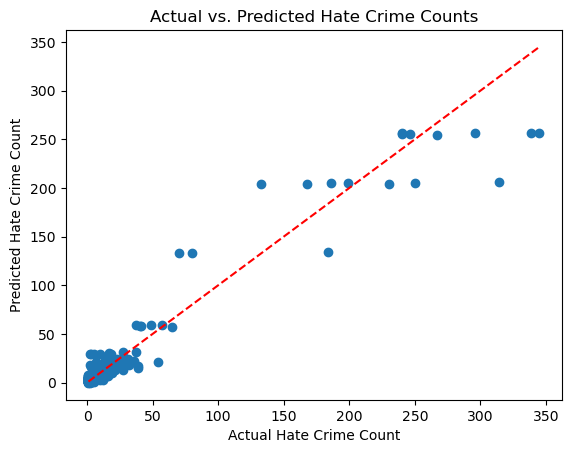

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Hate Crime Count')
plt.ylabel('Predicted Hate Crime Count')
plt.title('Actual vs. Predicted Hate Crime Counts')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Diagonal line

plt.show()

In [ ]:

contingency_table = pd.crosstab(new_df['state_name'], new_df['hate_crime_count'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print('Chi-square statistic:', chi2)
print('p-value:', p)

Chi-square statistic: 7472.37029473799
p-value: 0.7297922475710367


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Initialize and train the decision tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_dt = dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print('Decision Tree MSE:', mse_dt)

Decision Tree MSE: 208.77551020408163


### Feature Engineering and Model Building ADL Data
This data includes up until 2023 - because of the increase in rates, using the same linear model doesn't work as well.

BREAK THIS DOWN INTO EACH PART

In [ ]:
# Group the data by 'data_year' and 'state_name' and count the number of hate crimes for each group
hate_crime_counts = adl_antisemetic_data.groupby(['data_year', 'state']).size().reset_index(name='hate_crime_count')

# Create a new DataFrame with 'data_year', 'state_name', and 'hate_crime_count'
new_df = hate_crime_counts.copy()

X = new_df[['data_year', 'state']]
y = new_df['hate_crime_count']


# Perform one-hot encoding for categorical features
X_encoded = pd.get_dummies(X, columns=['state'])

# Train-Test Split
X_train, X_test, y_train, adl_y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Model Training
model = LinearRegression()
model.fit(X_train, y_train)

# Model Evaluation
adl_y_pred = model.predict(X_test)
mse = mean_squared_error(adl_y_test, adl_y_pred)
print('Mean Squared Error:', mse)

plt.scatter(adl_y_test, adl_y_pred)
plt.xlabel('Actual Hate Crime Count')
plt.ylabel('Predicted Hate Crime Count')
plt.title('Actual vs. Predicted Hate Crime Counts')

plt.plot([min(adl_y_test), max(adl_y_test)], [min(adl_y_test), max(adl_y_test)], color='red', linestyle='--')  # Diagonal line

plt.show()


contingency_table = pd.crosstab(new_df['state'], new_df['hate_crime_count'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print('Chi-square statistic:', chi2)
print('p-value:', p)

# Initialize and train the decision tree model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred_dt = dt_model.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
print('Decision Tree MSE:', mse_dt)

## Insight & Policy Decision
- Summarize key insights and conclusions drawn from the analysis.
- Propose potential policy recommendations or interventions based on the analysis.
- Reflect on the limitations of the study and areas for future research.

COMPARE THE TWO MODELS. 

COMPARE THE TWO???

Trend Analysis: Summarize the trends observed in hate crime data, including overall counts, distribution across bias types, and changes over time.  
Geographical Analysis: Highlight any geographic patterns in hate crime occurrence, such as hotspots or differences between states.  
Bias Types: Discuss the prevalence of different bias types, focusing on significant findings, such as an increase in anti-Semitic acts.  
Predictive Modeling: Reflect on the predictive modeling results, including the accuracy of the models and their potential utility in forecasting hate crime counts.  

Policy Implications:
Targeted Interventions: Discuss the need for targeted interventions in areas with high hate crime rates or specific bias types, based on the geographic and bias type analysis.
Community Engagement: Emphasize the importance of community engagement and support programs to address underlying causes of hate crimes and promote tolerance and understanding.
Law Enforcement Training: Advocate for specialized training for law enforcement agencies to effectively identify, report, and respond to hate crimes.
Legislative Measures: Propose legislative measures to strengthen hate crime laws, enhance reporting mechanisms, and ensure adequate support for victims and affected communities.



In the "Insight & Policy Decision" section, you'll summarize the key findings and their implications for policymakers, law enforcement, or advocacy groups. Here's what you can include:

Key Insights:
Trend Analysis: Summarize the trends observed in hate crime data, including overall counts, distribution across bias types, and changes over time.
Geographical Analysis: Highlight any geographic patterns in hate crime occurrence, such as hotspots or differences between states.
Bias Types: Discuss the prevalence of different bias types, focusing on significant findings, such as an increase in anti-Semitic acts.
Predictive Modeling: Reflect on the predictive modeling results, including the accuracy of the models and their potential utility in forecasting hate crime counts.
Policy Implications:
Targeted Interventions: Discuss the need for targeted interventions in areas with high hate crime rates or specific bias types, based on the geographic and bias type analysis.
Community Engagement: Emphasize the importance of community engagement and support programs to address underlying causes of hate crimes and promote tolerance and understanding.
Law Enforcement Training: Advocate for specialized training for law enforcement agencies to effectively identify, report, and respond to hate crimes.
Legislative Measures: Propose legislative measures to strengthen hate crime laws, enhance reporting mechanisms, and ensure adequate support for victims and affected communities.
Limitations and Future Research:
Data Limitations: Acknowledge any limitations in the data analysis, such as incomplete or biased datasets, and discuss how these limitations may impact the conclusions drawn.
Need for Further Study: Identify areas for future research, such as exploring the root causes of hate crimes, evaluating the effectiveness of policy interventions, or examining the long-term impact of hate crime legislation.
Conclusion:
Call to Action: Conclude with a call to action, emphasizing the importance of addressing hate crimes and promoting inclusivity, tolerance, and respect in society.
Commitment to Change: Express a commitment to continuing efforts to combat hate crimes and work towards a more equitable and just society.